In [19]:
import PIL
import os
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
import torch.utils.data.dataloader as DataLoader
import torchvision.transforms as transforms
class CustomDataset(Dataset):
    def __init__(self, label_file_path):
        with open(label_file_path, 'r') as f:
            # (image_path(str), image_label(str))
            self.imgs = list(map(lambda line: line.strip().split(' '), f))
            self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(),
            transforms.Resize((32,32)),
            transforms.ToTensor()])
            #prepare dataset and preprocessing
            # self.transform  = transforms.Compose([
            #     transforms.ToPILImage(),
            #     transforms.Resize(32),
            #     transforms.RandomCrop(32, padding=4),
            #     transforms.RandomHorizontalFlip(),
            #     transforms.ToTensor(),
            #     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            # ])
            
    def __getitem__(self, index):
        path, label = self.imgs[index]
        img = PIL.Image.open(path).convert('RGB')
        img = cv2.cvtColor(np.asarray(img), cv2.COLOR_RGB2BGR)
        img = self.transform(img)
        label = int(label)
        return img, label
    def __len__(self): #这个函数也必须要写，它返回的是数据集的长度，也就是多少张图片，要和loader的长度作区分
        return len(self.imgs)
train_data=CustomDataset(r'incremental-fewshot-dataset\Dataset\trainval\base\train_base.txt')
# for i, item in enumerate(train_data):
#         data, label = item
#         print('data:', data)
#         print('label:', label)


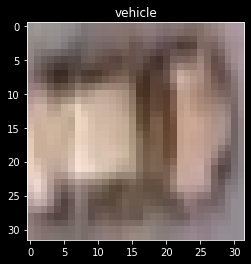

In [20]:
# 利用dataloader读取我们的数据对象，并设定batch-size和工作现场
classes = ['airplane', 'airport', 'baseballfield', 'basketballcourt', 'bridge', 'chimney', 'dam', 
            'Expressway-Service-area', 'Expressway-toll-station', 'golffield', 
            'groundtrackfield', 'harbor', 'overpass', 'ship', 'stadium',
            'storagetank', 'tenniscourt', 'trainstation', 'vehicle', 'windmill']

import matplotlib.pyplot as plt
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=4,
                                             shuffle=True, num_workers=0)
batch = iter(train_dataloader).next()
# print(batch)
test_img = batch[0][0].transpose(0,2).transpose(0,1).numpy()
test_label = batch[1][0]
# print(test_img)
# print(test_label)
plt.figure("batch test image") #图像窗口名称
plt.imshow(test_img)
plt.axis('on') #关掉坐标轴为off
plt.title(classes[test_label]) #图像标题
plt.show()



In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#定义残差块ResBlock
class ResBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(ResBlock, self).__init__()
        #这里定义了残差块内连续的2个卷积层
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            #shortcut，这里为了跟2个卷积层的结果结构一致，要做处理
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        #将2个卷积层的输出跟处理过的x相加，实现ResNet的基本结构
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

In [22]:
class ResNet18(nn.Module):
    def __init__(self, ResBlock, num_classes=20):
        super(ResNet18, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(ResBlock, 64, 2, stride=1)
        self.layer2 = self.make_layer(ResBlock, 128, 2, stride=2)
        self.layer3 = self.make_layer(ResBlock, 256, 2, stride=2)        
        self.layer4 = self.make_layer(ResBlock, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
    #这个函数主要是用来，重复同一个残差块    
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        #在这里，整个ResNet18的结构就很清晰了
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [23]:


#set hyperparameter
EPOCH = 20
pre_epoch = 0
BATCH_SIZE = 128
LR = 0.01


In [24]:
torch.cuda.empty_cache()

In [25]:
#define ResNet18
#check gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
net = ResNet18(ResBlock).to(device)

cuda


In [26]:
#define loss funtion & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9, weight_decay=5e-4)

In [27]:
#train
for epoch in range(pre_epoch, EPOCH):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(train_dataloader, 0):
        #prepare dataset
        length = len(train_dataloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))

torch.save(net, 'runs/model.pth')




Epoch: 1
[epoch:1, iter:1] Loss: 3.802 | Acc: 0.000% 
[epoch:1, iter:2] Loss: 2.695 | Acc: 37.500% 
[epoch:1, iter:3] Loss: 2.097 | Acc: 50.000% 
[epoch:1, iter:4] Loss: 2.245 | Acc: 50.000% 
[epoch:1, iter:5] Loss: 2.084 | Acc: 50.000% 
[epoch:1, iter:6] Loss: 2.018 | Acc: 50.000% 
[epoch:1, iter:7] Loss: 1.834 | Acc: 53.571% 
[epoch:1, iter:8] Loss: 1.732 | Acc: 50.000% 
[epoch:1, iter:9] Loss: 1.813 | Acc: 47.222% 
[epoch:1, iter:10] Loss: 3.206 | Acc: 50.000% 
[epoch:1, iter:11] Loss: 3.097 | Acc: 52.273% 
[epoch:1, iter:12] Loss: 3.186 | Acc: 50.000% 
[epoch:1, iter:13] Loss: 3.033 | Acc: 50.000% 
[epoch:1, iter:14] Loss: 2.874 | Acc: 51.786% 
[epoch:1, iter:15] Loss: 2.724 | Acc: 53.333% 
[epoch:1, iter:16] Loss: 2.726 | Acc: 53.125% 
[epoch:1, iter:17] Loss: 2.731 | Acc: 52.941% 
[epoch:1, iter:18] Loss: 2.646 | Acc: 52.778% 
[epoch:1, iter:19] Loss: 2.683 | Acc: 50.000% 
[epoch:1, iter:20] Loss: 2.923 | Acc: 47.500% 
[epoch:1, iter:21] Loss: 2.884 | Acc: 46.429% 
[epoch:1, ite

In [28]:
transform_test = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((32,32)),
            transforms.ToTensor()])


In [29]:
test_data=CustomDataset(r'incremental-fewshot-dataset\Dataset\test\session_base\test_base.txt')
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

In [30]:
net = torch.load('runs/model.pth')
net.eval()

ResNet18(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer1): Sequential(
    (0): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential()
    )
    (1): ResBlock(
      (left): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=Tru

In [31]:
#test

sum_loss = 0.0
correct = 0.0
total = 0.0
for i, data in enumerate(test_dataloader, 0):
    #prepare dataset
    length = len(test_dataloader)
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    
    #forward & backward
    outputs = net(inputs)
    
    #print ac & loss in each batch
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += predicted.eq(labels.data).cpu().sum()
print('Acc: %.3f%% ' % (100. * correct / total))

Acc: 91.637% 


In [32]:
# session 1 train

session1_train_data=CustomDataset(r'incremental-fewshot-dataset\Dataset\trainval\novel\session1\train_novel.txt')
session1_train_dataloader = torch.utils.data.DataLoader(session1_train_data, batch_size=4,shuffle=True, num_workers=0)

session1_epoch = 10

old_net = torch.load('runs/model.pth')
# print(old_net[])
net = ResNet18(ResBlock, num_classes=10+1).to(device)
# net_dict = net.state_dict()

# net.load_state_dict(old_net.state_dict(), strict=False)
# net.train()


# Use when some parts of pretrained model are not needed
pretrained_dict = torch.load('runs/model.pth').state_dict()
net_dict = net.state_dict()

# for k,v in pretrained_dict.items():
#     print(k,v)
 
# # 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
del pretrained_dict['fc.weight']
del pretrained_dict['fc.bias']
# # 2. overwrite entries in the existing state dict
net_dict.update(pretrained_dict) 
# # 3. load the new state dict
net.load_state_dict(net_dict)

for epoch in range(0, session1_epoch):
    print('\nEpoch: %d' % (epoch + 1))
    net.train()
    sum_loss = 0.0
    correct = 0.0
    total = 0.0
    for i, data in enumerate(session1_train_dataloader, 0):
        #prepare dataset
        length = len(session1_train_dataloader)
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        
        #forward & backward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #print ac & loss in each batch
        sum_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.eq(labels.data).cpu().sum()
        print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
              % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1), 100. * correct / total))

torch.save(net, 'runs/session1/model.pth')



Epoch: 1
[epoch:1, iter:1] Loss: 2.412 | Acc: 0.000% 
[epoch:1, iter:2] Loss: 2.421 | Acc: 0.000% 
[epoch:1, iter:3] Loss: 2.421 | Acc: 0.000% 
[epoch:1, iter:4] Loss: 2.424 | Acc: 0.000% 
[epoch:1, iter:5] Loss: 2.423 | Acc: 0.000% 
[epoch:1, iter:6] Loss: 2.417 | Acc: 0.000% 
[epoch:1, iter:7] Loss: 2.416 | Acc: 0.000% 
[epoch:1, iter:8] Loss: 2.415 | Acc: 0.000% 

Epoch: 2
[epoch:2, iter:9] Loss: 2.408 | Acc: 0.000% 
[epoch:2, iter:10] Loss: 2.409 | Acc: 0.000% 
[epoch:2, iter:11] Loss: 2.412 | Acc: 0.000% 
[epoch:2, iter:12] Loss: 2.409 | Acc: 0.000% 
[epoch:2, iter:13] Loss: 2.409 | Acc: 0.000% 
[epoch:2, iter:14] Loss: 2.411 | Acc: 0.000% 
[epoch:2, iter:15] Loss: 2.409 | Acc: 0.000% 
[epoch:2, iter:16] Loss: 2.409 | Acc: 0.000% 

Epoch: 3
[epoch:3, iter:17] Loss: 2.406 | Acc: 0.000% 
[epoch:3, iter:18] Loss: 2.406 | Acc: 0.000% 
[epoch:3, iter:19] Loss: 2.414 | Acc: 0.000% 
[epoch:3, iter:20] Loss: 2.412 | Acc: 0.000% 
[epoch:3, iter:21] Loss: 2.412 | Acc: 0.000% 
[epoch:3, ite